In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.meshtools as mt

from pygimli.viewer.mpl import drawMesh
from pygimli.physics import TravelTimeManager
from math import sin, cos, tan, asin, acos

In [36]:
# --- Membuat Mesh untuk Model 3 Lapisan ---
mesh_layer = mt.createGrid(                    # Membuat grid rectangular (2D)
    np.arange(0, 150, step=5, dtype=float),    # Arah X: dari 0 sampai 150 m dengan interval 5 m
    np.linspace(-70, 0, 13)                    # Arah Y: dari 0 (permukaan) hingga -70 m (kedalaman)
)

In [37]:
# --- Menetapkan Nilai Kecepatan untuk Tiap Lapisan ---
vel_layer = np.zeros(mesh_layer.cellCount())   # Membuat array kosong untuk menyimpan nilai kecepatan
for cell in mesh_layer.cells():                # Loop untuk setiap cell dalam mesh
    if cell.center().y() <= -40:               # Jika kedalaman lebih dari 40 m → lapisan 3
        vel = 4000.0                           # Kecepatan gelombang lapisan 3 = 4000 m/s
    elif cell.center().y() <= -20:             # Jika kedalaman antara 20–40 m → lapisan 2
        vel = 2000.0                           # Kecepatan gelombang lapisan 2 = 2000 m/s
    else:                                      # Jika di atas -20 m → lapisan 1 (permukaan)
        vel = 500.0                            # Kecepatan gelombang lapisan 1 = 500 m/s
    vel_layer[cell.id()] = vel                 # Simpan nilai kecepatan ke dalam array berdasarkan ID cell

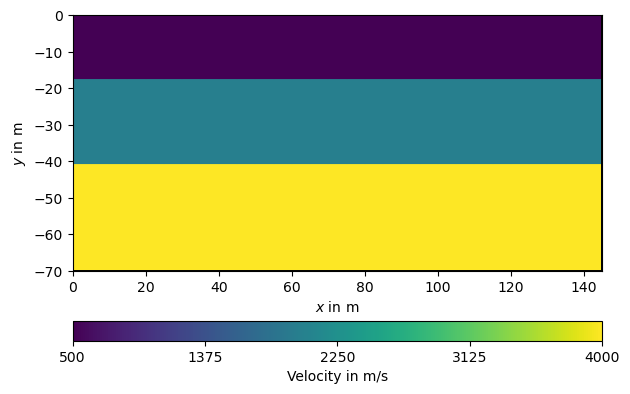

In [38]:
# --- Visualisasi Model 3 Lapisan ---
ax, cb = pg.show(                              # Fungsi bawaan PyGIMLi untuk menampilkan model mesh
    mesh_layer,                                # Mesh yang digunakan
    vel_layer,                                 # Nilai kecepatan tiap cell
    label='Velocity in m/s'                   # Label colorbar
    )

In [39]:
# --- Membuat Mesh untuk Model Gradien Kecepatan ---
sensors = np.arange(131, step=10)              # Titik sensor pada permukaan setiap 10 m
plc = mt.createWorld([0, -70], [150, 0], worldMarker=False)  # Domain model: 0–150 m dan kedalaman -80 m
for pos in sensors:                            # Tambahkan node sensor di permukaan
    plc.createNode([pos, 0])
mesh_grad = mt.createMesh(plc, quality=33, area=3)  # Buat mesh dari definisi domain dengan kualitas tertentu

# --- Parameter Model Gradien Kecepatan ---
a = 500                                        # Kecepatan awal di permukaan (m/s)
b = 50                                         # Laju peningkatan kecepatan per meter

vel_grad = []                                  # Array kosong untuk menyimpan kecepatan tiap node
for node in mesh_grad.nodes():                 # Loop tiap node dalam mesh
    vel_grad.append(a + b * abs(node.y()))     # Kecepatan bertambah secara linear terhadap kedalaman (|y|)
vel_grad = pg.meshtools.nodeDataToCellData(mesh_grad, np.array(vel_grad))

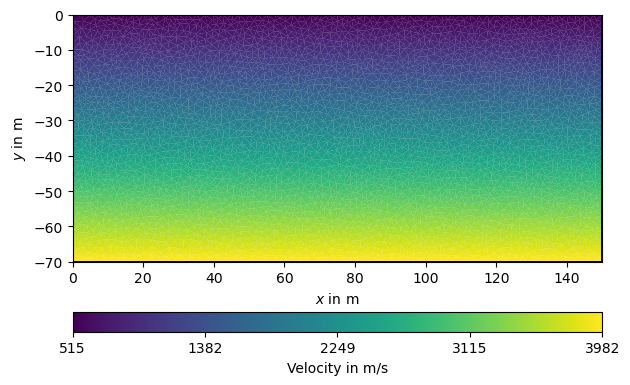

In [40]:
# --- Visualisasi Model Gradien Kecepatan ---
ax, cb = pg.show(                              # Tampilkan mesh dengan peta kecepatan gradien
    mesh_grad, vel_grad,
    label='Velocity in m/s'
)

In [41]:
# --- Fungsi Analitik untuk Model 3 Lapisan ---
def analyticalSolution3Layer(x, z1=20, z2=60, v1=500, v2=2000, v3=4000):
    x = np.abs(x)                              # Pastikan jarak positif (simetri terhadap sumber)
    
    tdirect = x / v1                           # Waktu tempuh gelombang langsung di lapisan 1

    # --- Gelombang Refraksi Lapisan 2 ---
    if v2 > v1:                                # Jika kecepatan lapisan 2 > lapisan 1 (refraksi bisa terjadi)
        alfal2 = asin(v1 / v2)                 # Sudut kritis sesuai hukum Snell
        xcritl2 = 2 * z1 * tan(alfal2)         # Jarak kritis tempat refraksi pertama muncul
        trefl2 = (2 * z1 * cos(alfal2) / v1) + ((x - xcritl2) / v2)  # Waktu refraksi lapisan 2
    else:
        tref12 = np.inf * np.ones_like(x)         # Tidak ada refraksi jika v2 <= v1

    # --- Gelombang Refraksi Lapisan 3 ---
    if v3 > v2:                                # Jika lapisan 3 lebih cepat dari lapisan 2
        alfal3 = asin(v2 / v3)                 # Sudut kritis antara lapisan 2–3
        xcritl3 = 2 * (z1 * tan(alfal3) + z2 * tan(alfal3))  # Jarak kritis ke-2
        trefl3 = (2 * z1 / (v1 * np.cos(alfal3)) + 2 * z2 / (v2 * np.cos(alfal3)) +  (x - xcritl3) / v3)
    else:
        trefl3 = np.inf * np.ones_like(x)                         # Tidak ada refraksi jika v3 <= v2
        
    return np.minimum(tdirect, np.minimum(trefl2, trefl3))               # Kembalikan waktu tempuh untuk tiap mode gelombang

In [42]:
def analyticalSolutionGradient(x, a=1000, b=100):
    """Analytical solution for gradient model."""
    tdirect = np.abs(x) / a  # direct wave
    tmp = 1 + ((b**2 * np.abs(x)**2) / (2 * a**2))
    trefrac = np.abs(b**-1 * np.arccosh(tmp))
    return np.minimum(tdirect, trefrac)

################################################################################
#                                   layered                                    #
################################################################################


16/10/25 - 01:18:23 - pyGIMLi - INFO - Creating refined mesh (secnodes: 1) to solve forward task.
16/10/25 - 01:18:23 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Raytracing with 0 secondary nodes: Elapsed time is 0.01 seconds.
Raytracing with 1 secondary nodes: Elapsed time is 0.03 seconds.


16/10/25 - 01:18:24 - pyGIMLi - INFO - Creating refined mesh (secnodes: 10) to solve forward task.


Raytracing with 5 secondary nodes: Elapsed time is 0.29 seconds.
Raytracing with 10 secondary nodes: Elapsed time is 0.91 seconds.
################################################################################
#                                   gradient                                   #
################################################################################


16/10/25 - 01:18:27 - pyGIMLi - INFO - Creating refined mesh (secnodes: 1) to solve forward task.


Raytracing with 0 secondary nodes: Elapsed time is 0.10 seconds.
Raytracing with 1 secondary nodes: Elapsed time is 0.44 seconds.


16/10/25 - 01:18:28 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


Raytracing with 5 secondary nodes: Elapsed time is 3.05 seconds.


16/10/25 - 01:18:37 - pyGIMLi - INFO - Creating refined mesh (secnodes: 10) to solve forward task.


Raytracing with 10 secondary nodes: Elapsed time is 11.14 seconds.


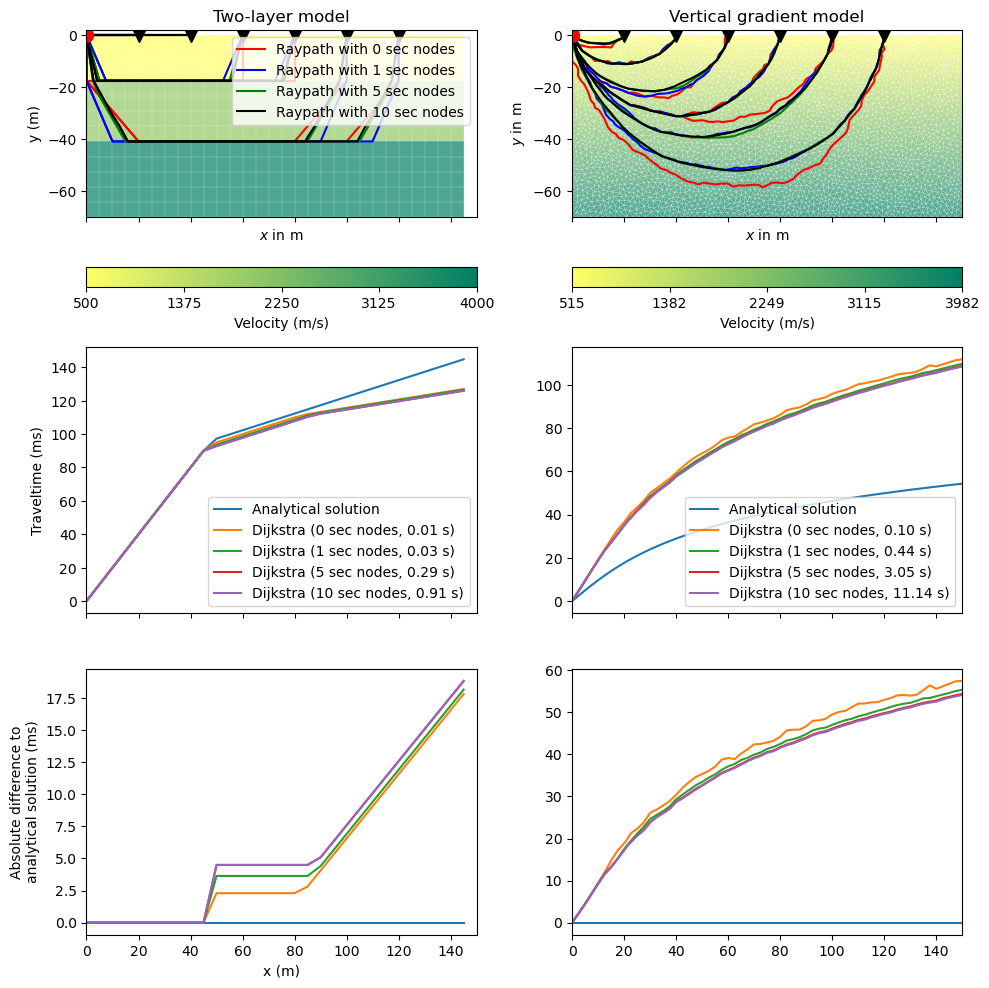

In [43]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10), sharex=True)  # Membuat figure dengan 3 baris dan 2 kolom subplot

for j, (case, mesh, vel) in enumerate(zip(["layered", "gradient"],
                                          [mesh_layer, mesh_grad],
                                          [vel_layer, vel_grad])):  # Loop untuk dua model: layered dan gradient
    pg.boxprint(case)  # Menampilkan nama kasus di terminal

    if case == "gradient":
        ana = analyticalSolutionGradient  # Fungsi solusi analitik untuk model gradien
    elif case == "layered":
        ana = analyticalSolution3Layer    # Fungsi solusi analitik untuk model tiga lapisan

    for boundary in mesh.boundaries():
        boundary.setMarker(0)  # Reset marker untuk semua batas mesh

    xmin, xmax = mesh.xmin(), mesh.xmax()  # Menentukan batas x dari mesh
    mesh.createNeighborInfos()  # Membangun hubungan antar sel pada mesh

    mx = pg.x(mesh)  # Mengambil koordinat x dari node mesh
    my = pg.y(mesh)  # Mengambil koordinat y dari node mesh
    px = np.sort(mx[my == 0.0])  # Mengambil posisi sensor di permukaan (y=0)

    data = pg.DataContainer()  # Membuat wadah data untuk shot dan receiver
    data.registerSensorIndex('s')  # Registrasi indeks untuk sumber
    data.registerSensorIndex('g')  # Registrasi indeks untuk receiver

    for i, pxi in enumerate(px):  # Loop untuk membuat sensor di setiap posisi x
        data.createSensor([pxi, 0.0])  # Membuat sensor di permukaan
        if pxi == 0.0:
            source = i  # Menentukan sensor pertama (x=0) sebagai sumber

    nData = len(px)  # Jumlah data (jumlah sensor)
    data.resize(nData)  # Ubah ukuran container sesuai jumlah sensor
    data['s'] = [source] * nData  # Semua sensor menggunakan satu sumber (shot tunggal)
    data['g'] = range(nData)  # Setiap sensor berperan sebagai receiver

    # Menampilkan peta kecepatan pada subplot atas
    pg.show(mesh, vel, ax=ax[0, j], label="Velocity (m/s)", hold=True,
            logScale=False, cMap="summer_r", coverage=0.7)
    drawMesh(ax[0, j], mesh, color="white", lw=0.21)  # Gambar garis batas mesh

    sec_nodes = [0, 1, 5, 10]  # Jumlah secondary nodes untuk uji akurasi raypath
    t_all = []        # Menyimpan hasil waktu tempuh
    durations = []    # Menyimpan waktu komputasi
    paths = []        # Menyimpan lintasan ray

    mgr = TravelTimeManager()  # Inisialisasi TravelTimeManager untuk perhitungan waktu tempuh

    cols = ["red", "blue", "green", "black"]  # Warna untuk masing-masing jumlah sec_nodes
    recs = [2, 4, 6, 8, 10, 12]  # Indeks receiver yang ditampilkan raypath-nya

    for i, n in enumerate(sec_nodes):  # Loop untuk setiap jumlah secondary nodes
        pg.tic()  # Mulai timer
        res = mgr.simulate(vel=vel, scheme=data, mesh=mesh, secNodes=n)  # Simulasi raytracing
        t_all.append(res['t'].array())  # Simpan hasil waktu tempuh
        durations.append(pg.dur())  # Simpan durasi eksekusi
        pg.toc("Raytracing with %d secondary nodes:" % n)  # Cetak waktu proses

        for r, p in enumerate(recs):  # Loop untuk setiap receiver yang dipilih
            if r == 0:
                lab = "Raypath with %d sec nodes" % n  # Label untuk legend
            else:
                lab = None  # Label hanya untuk raypath pertama

            recNode = mgr.fop.mesh().findNearestNode([sensors[p], 0.0])  # Node receiver terdekat
            sourceNode = mgr.fop.mesh().findNearestNode([0.0, 0.0])      # Node sumber

            path = mgr.fop.dijkstra.shortestPath(sourceNode, recNode)  # Hitung lintasan terpendek (Dijkstra)
            points = mgr.fop.mesh().positions(withSecNodes=True)[path].array()  # Ambil koordinat lintasan
            ax[0, j].plot(points[:,0], points[:,1], cols[i], label=lab)  # Plot raypath

    t_ana = ana(px)  # Hitung solusi analitik waktu tempuh

    ax[1, j].plot(px, t_ana * 1000, label="Analytical solution")  # Plot solusi analitik pada subplot tengah

    for i, n in enumerate(sec_nodes):  # Plot hasil simulasi untuk tiap jumlah secondary nodes
        ax[1, j].plot(px, t_all[i] * 1000,
                      label="Dijkstra (%d sec nodes, %.2f s)" % (n, durations[i]))

    ax[2, j].plot(px, np.zeros_like(px), label="Zero line")  # Tambahkan garis nol untuk acuan

    for i, n in enumerate(sec_nodes):  # Plot selisih absolut hasil numerik dan analitik
        ax[2, j].plot(px, np.abs(t_all[i] - t_ana) * 1000)

    ax[1, j].legend()  # Tampilkan legenda di subplot tengah

    for p in recs:  # Plot posisi receiver
        ax[0, j].plot(sensors[p], 0.0, "kv", ms=10)  # Receiver (segitiga hitam)
    ax[0, j].plot(0.0, 0.0, "ro", ms=10)  # Source (lingkaran merah)
    ax[0, j].set_ylim(mesh.ymin(), 2)  # Atur batas bawah sumbu y

ax[0, 0].set_title("Two-layer model")  # Judul kolom pertama
ax[0, 1].set_title("Vertical gradient model")  # Judul kolom kedua
ax[0, 0].legend()  # Legenda untuk model pertama
ax[0, 0].set_ylabel("y (m)")  # Label sumbu y subplot atas
ax[1, 0].set_ylabel("Traveltime (ms)")  # Label sumbu y subplot tengah
ax[2, 0].set_ylabel("Absolute difference to\nanalytical solution (ms)")  # Label sumbu y subplot bawah
ax[2, 0].set_xlabel("x (m)")  # Label sumbu x
fig.tight_layout()  # Merapikan tata letak antar subplot
